# Deployment of Azure ML web services from Python 2 notebooks

While web services can be created directly within [Azure ML Studio](https://studio.azureml.net), in some cases it may be more straightforward to develop and deploy a web service entirely within a Python notebook. Python notebooks allow rapid prototyping and allow developers to include commentary in an easy-to-reference format. This tutorial will demonstrate how the [`azureml`](https://github.com/Azure/Azure-MachineLearning-ClientLibrary-Python) package can be used to deploy Azure ML web services directly from within a Python notebook (or other Python environment).

[An R version](https://notebooks.azure.com/library/MMYTqvZg30o) of this tutorial is also available on [Azure Notebooks](https://notebooks.azure.com/).

## Outline
- [Prerequisites for this tutorial](#Prerequisites-for-this-tutorial)
   - [Credentials needed to connect to your workspace](#Credentials-needed-to-connect-to-your-workspace)
- [Motivation: Beaver Fever](#Motivation:-Beaver-Fever)
   - [Loading and exploring the dataset](#Loading-and-exploring-the-dataset)
   - [Transferring data to and from Azure ML Studio](#Transferring-data-to-and-from-Azure-ML-Studio)
- [Creating the predictive model](#Creating-the-predictive-model)
- [Deploying the model as a web service](#Deploying-the-model-as-a-web-service)
- [Consuming the web service](#Consuming-the-web-service)
- [Next steps](#Next-steps)
- [Works cited](#Works-cited)

## Prerequisites for this tutorial
- Familiarity with Azure ML Studio
- A workspace in Azure ML Studio
- Familiarity with Python
- A Python notebook with the `AzureML` library installed (e.g. a Python notebook in [Azure Notebooks](https://notebooks.azure.com/))

### Credentials needed to connect to your workspace

The `azureml` package uses your workspace ID and authorization token to connect to the workspace. The instructions below will help you find this information if you are the workspace's owner; if you are an authorized user but not the owner of the workspace, ask the owner to help you obtain this information.

To find the credentials you'll need, navigate to your workspace on [Azure ML Studio](https://studio.azureml.net) and click on the "Settings" button on the left pane:

![Setttings button](http://i.imgur.com/gCGdrcZ.png)

The Name tab of the Settings page will be displayed. Your workspace ID is shown on this page: copy it into the indicated empty string in the code box below.

![Location of workspace ID](http://i.imgur.com/xboHVKM.png)

Then, click the Authorization Tokens tab and copy either token into the indicated empty string below.

![Location of authorization token](http://i.imgur.com/DLlcGdY.png)

Finally, execute the code box by selecting it and pressing Ctrl+Enter:

In [3]:
import azureml
workspace_id = 'f7396516bb7b460484e9e444cdcc4ebf'
authorization_token = 'ff2945540a23487796afe0e01190ecdb'
ws = azureml.Workspace(workspace_id, authorization_token)

If the code box executed without error, you are ready to begin the tutorial!

## Motivation: Beaver Fever

Reynolds (1994) collected data on the body temperatures of female beavers living in Wisconsin. We will use this dataset to train a decision tree model which predicts a beaver's body temperature. Then we will create a web service based on this model that can be used to predict body temperatures for other beavers.

## Loading and exploring the dataset

Our dataset contains the following features:
- `time`: The time of day on which the recording was made
- `activ`: Binary indicator of whether activity is occurring outside of the beaver lodge
- `beaver`: The beaver being measured
- `temp`: The recorded body temperature

Let's load the dataset and plot each of these features on the same axes to see whether any patterns may be present:

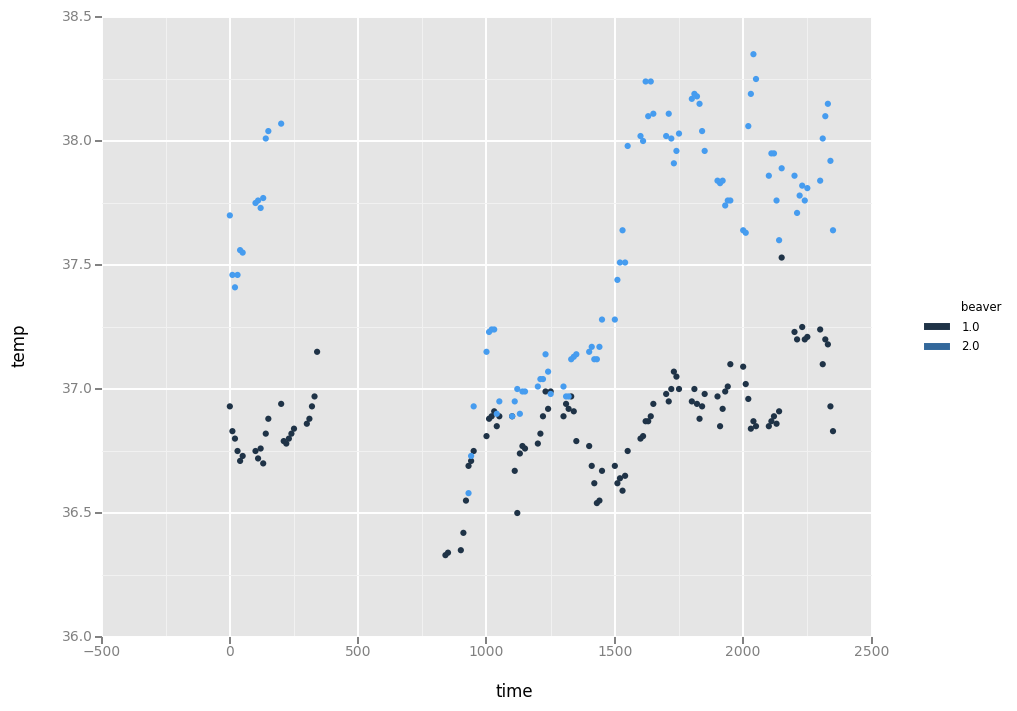

<ggplot: (8791965639037)>

In [4]:
!pip install pydataset --disable-pip-version-check -q
import pandas as pd
from pydataset import data

df = data('beav1')
df['beaver'] = 1
df = pd.concat([df, data('beav2')])
df.loc[df['beaver'].isnull(), 'beaver'] = 2
df.drop('day', 1, inplace=True)

%matplotlib inline
from ggplot import *
ggplot(aes(x='time', y='temp', color='beaver'), data=df) + geom_point()

Plotting the data reveals some conspicuous patterns. Beavers tend to be warmer when there is activity nearby, which tends to be in the afternoon and evening hours:

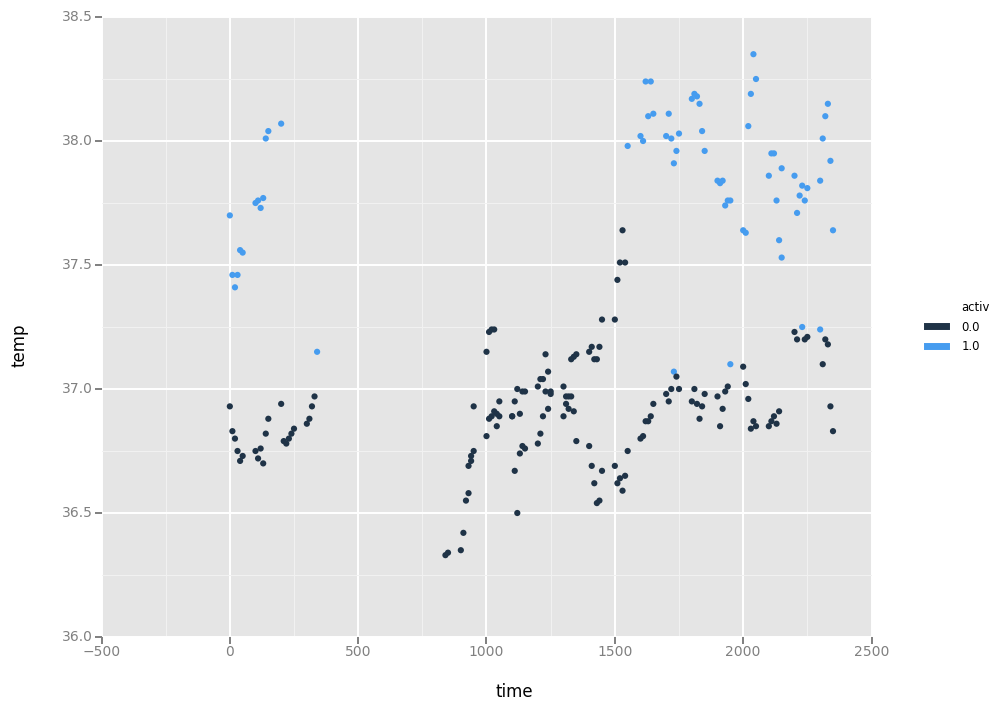

<ggplot: (8791972548737)>

In [5]:
ggplot(aes(x='time', y='temp', color='activ'), data=df) + geom_point()

It also appears that all else being equal, Beaver 2 is warmer than Beaver 1.

Notice that some trends seem to apply to a subset of the data. For example, if the measurement is from Beaver 2 *and* the beaver was active, then the body temperature is likely to be above 37.5; otherwise, the temperature is likely below 37.5. When trends apply to observation subsets that can be clearly defined using thresholding, decision tree models are good candidates. We will therefore implement a decision tree model in the next section of the tutorial.

### Transferring data to and from Azure ML Studio

Below, we will create a predictive model entirely in Azure Notebooks. However, if you preferred, you could use the `azureml` Python program to transfer the data over to Azure ML Studio to create your model there:

In [6]:
dataset = ws.datasets.add_from_dataframe(dataframe=df,
                                         data_type_id=azureml.DataTypeIds.GenericCSV,
                                         name='Beaver Body Temperature Data',
                                         description='From Reynolds 1994 via pydataset')

The output after issuing the command above, we can see the dataset listed in the Datasets section of the workspace:

![Dataset upload was successful](http://i.imgur.com/3ykERw4.png)

It is also straightforward to list the datasets available in the workspace and transfer datasets from the workspace to the notebook:

In [7]:
print('\n'.join([i.name for i in ws.datasets if not i.is_example])) # only list user-created datasets

Beaver Body Temperature Data


In [8]:
# Read some more of the metadata
ds = ws.datasets['Beaver Body Temperature Data']
print(ds.name)
print(ds.description)
print(ds.family_id)
print(ds.data_type_id)
print(ds.created_date)
print(ds.size)

# Read the contents
df2 = ds.to_dataframe()
df2.head()

Beaver Body Temperature Data
From Reynolds 1994 via pydataset
cb05967e8a8e4801b2d463e1daa07070
GenericCSV
2016-09-21 01:04:27.061000
3579


,activ,beaver,temp,time
0,0,1.0,36.33,840
1,0,1.0,36.34,850
2,0,1.0,36.35,900
3,0,1.0,36.42,910
4,0,1.0,36.55,920


## Creating the predictive model

To assess overfitting, we will train our decision tree using only a subset of the available data. We can then assess performance using the withheld observation. Below, `sklearn`'s `train_test_split()` function is used to select 70% of the data points for training and 30% for validation.

In [15]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df[['activ', 'beaver', 'time']],
                                                    df['temp'],
                                                    test_size=0.3,
                                                    random_state=42)

We can fit `scikit-learn`'s `DecisionTreeRegressor` model using the training data, then make predictions about the withheld body temperature measurements:

In [16]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score

regressor = DecisionTreeRegressor(random_state=42)
regressor.fit(X_train, y_train)
y_test_predictions = regressor.predict(X_test)
print('R^2 for true vs. predicted test set temperature measurements: {:0.2f}'.format(r2_score(y_test, y_test_predictions)))

R^2 for true vs. predicted test set temperature measurements: 0.94


It seems like we have a reasonably accurate model!



## Deploying the model as a web service

To deploy our model as a predictive web service, we create a wrapper function that takes input data as an argument and calls `predict()` with our trained model and this input data, returning the results.

In [18]:
from azureml import services
@services.publish(workspace_id, authorization_token)
@services.types(activ=int, beaver=float, time=int)
@services.returns(float)

# The name of your web service will be determined by this function's name
def beaver_body_temp_predictor(activ, beaver, time):
    return regressor.predict([activ, beaver, time])

# hold onto information about your web service so you can call it within the notebook later
service_url = beaver_body_temp_predictor.service.url 
api_key = beaver_body_temp_predictor.service.api_key
help_url = beaver_body_temp_predictor.service.help_url
service_id = beaver_body_temp_predictor.service.service_id

## Consuming the web service

While you are in the notebook session in which the web service was created, you can call the predictor directly:

In [19]:
beaver_body_temp_predictor.service(0, 1, 1200)

36.78

At any later time, you can use the stored API key and service URL to call the service:

In [20]:
import urllib2
import json

data = {"Inputs": {"input1": { "ColumnNames": [ "beaver", "activ", "time"],
                               "Values": [["1", "0", "1200"]] } }, # specified feature values
        "GlobalParameters": {} }
body = json.dumps(data)
headers = {'Content-Type':'application/json', 'Authorization':('Bearer '+ api_key)}
req = urllib2.Request(service_url, body, headers) 
try:
    response = urllib2.urlopen(req)
    result = json.loads(response.read())  # load json-formatted string response as dictionary
    print(result['Results']['output1']['value']['Values'][0][0]) # get the returned prediction
except urllib2.HTTPError, error:
    print("The request failed with status code: " + str(error.code))
    print(error.info())
    print(json.loads(error.read()))         

36.78


## Next steps

See the [git repo and documentation for the `azureml` package](https://github.com/Azure/Azure-MachineLearning-ClientLibrary-Python) for more information on the available functionality.

## Works cited
- P. S. Reynolds (1994). "Time-series analyses of beaver body temperatures." Chapter 11 of Lange, N., Ryan, L., Billard, L., Brillinger, D., Conquest, L. and Greenhouse, J. eds (1994) *Case Studies in Biometry*. New York: John Wiley and Sons.
